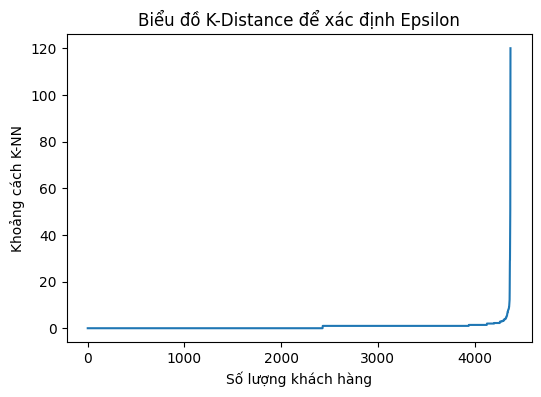

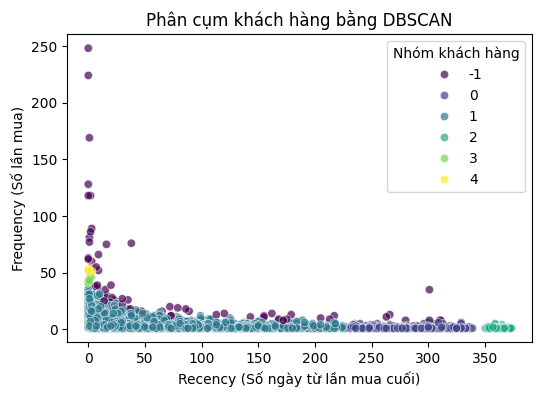

Silhouette Score: 0.07


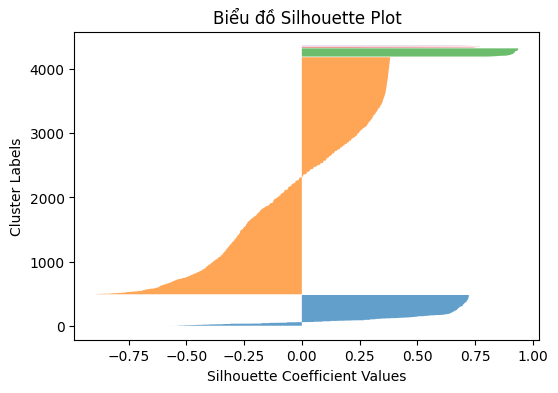

Phân cụm hoàn tất. Kết quả được lưu vào customer_segments.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples

# Đọc dữ liệu
file_path = r"C:\Users\PC\Documents\UEH\KPDL\Online Retail.xlsx"
df = pd.read_excel(file_path, sheet_name="Online Retail")

# Loại bỏ các dòng thiếu CustomerID
df = df.dropna(subset=["CustomerID"])
df["CustomerID"] = df["CustomerID"].astype(int)

# Xác định ngày cuối cùng trong tập dữ liệu
max_date = df["InvoiceDate"].max()

# Tính Recency
df_recency = df.groupby("CustomerID")["InvoiceDate"].max().reset_index()
df_recency["Recency"] = (max_date - df_recency["InvoiceDate"]).dt.days
df_recency = df_recency[["CustomerID", "Recency"]]

# Tính Frequency
df_frequency = df.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()
df_frequency.columns = ["CustomerID", "Frequency"]

# Gộp hai bảng lại
rfm_df = df_recency.merge(df_frequency, on="CustomerID")

# Xác định giá trị Epsilon bằng K-Distance
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(rfm_df[["Recency", "Frequency"]])
distances, indices = neigh.kneighbors(rfm_df[["Recency", "Frequency"]])

# Sắp xếp khoảng cách và vẽ biểu đồ K-Distance
distances = np.sort(distances[:, -1])
plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.xlabel("Số lượng khách hàng")
plt.ylabel("Khoảng cách K-NN")
plt.title("Biểu đồ K-Distance để xác định Epsilon")
plt.show()

# Áp dụng DBSCAN với giá trị Epsilon xác định
dbscan = DBSCAN(eps=3, min_samples=5)
rfm_df["Cluster"] = dbscan.fit_predict(rfm_df[["Recency", "Frequency"]])

# Vẽ biểu đồ phân cụm
plt.figure(figsize=(6, 4))
sns.scatterplot(data=rfm_df, x="Recency", y="Frequency", hue="Cluster", palette="viridis", alpha=0.7)
plt.xlabel("Recency (Số ngày từ lần mua cuối)")
plt.ylabel("Frequency (Số lần mua)")
plt.title("Phân cụm khách hàng bằng DBSCAN")
plt.legend(title="Nhóm khách hàng")
plt.show()

# Tính Silhouette Score (loại bỏ outliers)
rfm_filtered = rfm_df[rfm_df["Cluster"] != -1]
if len(rfm_filtered["Cluster"].unique()) > 1:
    silhouette_avg = silhouette_score(rfm_filtered[["Recency", "Frequency"]], rfm_filtered["Cluster"])
    print(f"Silhouette Score: {silhouette_avg:.2f}")
    
    # Vẽ biểu đồ Silhouette Plot
    silhouette_values = silhouette_samples(rfm_filtered[["Recency", "Frequency"]], rfm_filtered["Cluster"])
    plt.figure(figsize=(6, 4))
    y_lower = 10
    for i, cluster in enumerate(np.unique(rfm_filtered["Cluster"])):
        cluster_silhouette_values = silhouette_values[rfm_filtered["Cluster"] == cluster]
        cluster_silhouette_values.sort()
        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)
        y_lower = y_upper + 10
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Labels")
    plt.title("Biểu đồ Silhouette Plot")
    plt.show()
else:
    print("Không đủ cụm hợp lệ để tính Silhouette Score.")

# Lưu kết quả phân cụm
rfm_df.to_csv("customer_segments.csv", index=False)
print("Phân cụm hoàn tất. Kết quả được lưu vào customer_segments.csv")
